# jsn_sr04t 

Perfil del jsn_sr04t Sensor Ultrasónico de Distancia

* Update Interval: 100ms
* Mean: 1.896mA
* 95% quantile: 8.4mA
* Max: 9.6mA

In [1]:
from collections import defaultdict
import json
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import numpy as np
import pandas as pd
from sklearn.mixture import GaussianMixture

In [2]:
experiment = "jsn_sr04t"
power_profiler_freq = "10ms"
board = "nodemcu"
update_interval = "100ms"
test_num = 1 #Test_number

batteries = [0.8, 2, 4, 10] #Ah
deep_sleep_times = [0, 10, 30, 60, 60*10, 60*15, 60*30, 60*60] #seg

## Code

In [3]:
def load_data(filename, show=False):
    try:
        df = pd.read_csv(filename)
        if show:
            display(df.head())
    except FileNotFoundError:
        print(f"Error: '{fn}' not found.")
    except pd.errors.ParserError:
        print("Error: Unable to parse the CSV file. Check the file format.")
    except Exception as e:
        print(f"An unexpected error occurred: {e}")
    return df

In [4]:
def preprocess(df): 
    '''
    Check for missing values
    '''
    missing_values = df['current'].isnull().sum()
    missing_percentage = (missing_values / len(df['current'])) * 100
    print(f"Missing values in 'current' column: {missing_values} ({missing_percentage:.2f}%)")

    # Determine data type and convert if necessary
    print(f"Original data type of 'current' column: {df['current'].dtype}")
    if not pd.api.types.is_numeric_dtype(df['current']):
        try:
            df['current'] = pd.to_numeric(df['current'], errors='coerce')
            print("Converted 'current' column to numeric type.")
        except Exception as e:
            print(f"Error converting 'current' column: {e}")
    print(f"Data type of 'current' column after conversion: {df['current'].dtype}")

    # Calculate descriptive statistics
    descriptive_stats = df['current'].describe()
    print("\nDescriptive Statistics for 'current' column:")
    print(descriptive_stats)
    return df

**Reasoning**:
Clean the 'current' column by removing outliers using the IQR method and impute any remaining missing values with the median.


**NOTA: ALGO SE VE RARO EN ESTO, REVISAR EL MÉTODO, PUEDE SER QUE NO ELIMINE NADA **

In [5]:
def clean(df):
    quantile_low = 0.25
    quantile_high = 0.75
    iqr_factor = 1.5

    # Calculate Q1, Q3, and IQR
    Q1 = df['current'].quantile(quantile_low)
    Q3 = df['current'].quantile(quantile_high)
    IQR = Q3 - Q1

    # Define bounds for outlier removal
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    print(f"IQR lower_bound: {lower_bound}, upper_bound: {upper_bound})")

    # Remove outliers
    org_len = len(df['current'])
    df = df[~((df['current'] < lower_bound) | (df['current'] > upper_bound))]
    removed_len = len(df['current'])
    print(f"Length before IQR bounds: {org_len}, after: {removed_len}")

    # Display descriptive statistics after outlier removal
    print("\nDescriptive Statistics for 'current' column after outlier removal:")
    print(df['current'].describe())

    # Handle any remaining missing values
    if df['current'].isnull().any():
        median_current = df['current'].median()
        df['current'].fillna(median_current, inplace=True)
        print("\nDescriptive Statistics for 'current' column after imputation:")
        print(df['current'].describe())
    else:
        print("\nNo missing values found after outlier removal.")
    return df

In [6]:
def gmm_fit(data, plot_results=False):
    """
    Finds a current threshold to separate high and low current usage modes using Gaussian Mixture Models.

    Args:
        data (pd.Series or np.array): The current usage data.
        plot_results (bool, optional): Whether to plot the histogram and GMM fit. Defaults to False.

    Returns:
        float: The current threshold separating the modes, or None if the fitting fails.
        array of means
        array of labels
    """

    if isinstance(data, pd.Series):
        data = data.values.reshape(-1, 1) #Reshape for sklearn
    elif isinstance(data, np.ndarray):
        data = data.reshape(-1, 1)
    else:
        raise TypeError("Input data must be a pandas Series or numpy array.")

    try:
        gmm = GaussianMixture(n_components=2)
        labels = gmm.fit_predict(data)
        means = gmm.means_.flatten()
        means.sort()  # Ensure means are sorted: low, high

        # Calculate the threshold as the midpoint between the means
        threshold = (means[0] + means[1]) / 2

        if plot_results:
            plt.hist(data, bins=50, density=True, alpha=0.6, color='g')
            x = np.linspace(data.min(), data.max(), 200).reshape(-1, 1)
            logprob = gmm.score_samples(x)
            pdf = np.exp(logprob)
            plt.plot(x, pdf, '-r')
            plt.axvline(threshold, color='b', linestyle='--', label=f'Threshold: {threshold:.4f}')
            plt.axvline(means[0], color="#888888", linestyle="--", label=f"Mean 0: {means[0]:.4f}")
            plt.axvline(means[1], color="#888888", linestyle="--", label=f"Mean 1: {means[1]:.4f}")
            plt.legend()
            plt.xlabel("Current")
            plt.ylabel("Density")
            plt.title("Current Usage Distribution and GMM Fit")
            plt.show()

        return threshold, means, labels

    except Exception as e:
        print(f"Error during GMM fitting: {e}")
        return None

#Example Usage
# Create a sample dataset (replace with your actual data)

In [7]:
def analyze_cycles(df):
    """
    Analyzes and separates high current usage cycles and deep sleep periods.
    """
    
    cycles = []
    # Iterate over the DataFrame and check for transitions between high and low current states.
    # This is a simplified representation, and the logic may need adjustment based on your specific requirements
    current_state = None
    start_time = None
    for index, row in df.iterrows():
        if row['state_label'] == "high":
            if current_state != "high":  # Transition to high current state
                if current_state == "low":
                    cycles.append({"state":"low", "start_time":start_time, "end_time": row['read_at']})
                current_state = "high"
                start_time = row['read_at']
        else:
            if current_state != "low":  # Transition to low current state
                if current_state == "high":
                    cycles.append({"state":"high", "start_time":start_time, "end_time": row['read_at']})
                current_state = "low"
                start_time = row['read_at']

    # Handle the last cycle
    if start_time:
        cycles.append({"state":current_state, "start_time":start_time, "end_time": df['read_at'].iloc[-1]})

    return cycles

## Analysis

In [11]:
experiment_name = f"--{board}_up{update_interval}-t{test_num}"
filename = f"../data/{experiment}-f{power_profiler_freq}{experiment_name}.csv"
print(experiment_name)
print(filename)
df = load_data(filename, True)
df = preprocess(df)
#df = clean(df)

--nodemcu_up100ms-t1
../data/jsn_sr04t-f10ms--nodemcu_up100ms-t1.csv


,index,read_at,millis,timestamp,voltage,current,power,bus_voltage
0,0,2025-03-12 17:02:43.712817,306021,2025-03-12 17:02:43,3.36,0.0048,0.01613,0.00048
1,1,2025-03-12 17:02:43.713350,306033,2025-03-12 17:02:43,3.36,0.0004,0.00134,0.00004
2,2,2025-03-12 17:02:43.713853,306044,2025-03-12 17:02:43,3.36,0.0004,0.00134,0.00004
3,3,2025-03-12 17:02:43.714575,306056,2025-03-12 17:02:43,3.36,0.0004,0.00134,0.00004
4,4,2025-03-12 17:02:43.715365,306103,2025-03-12 17:02:43,3.36,0.0004,0.00134,0.00004


Missing values in 'current' column: 0 (0.00%)
Original data type of 'current' column: float64
Data type of 'current' column after conversion: float64

Descriptive Statistics for 'current' column:
count    2642.000000
mean        0.001896
std         0.002649
min         0.000400
25%         0.000400
50%         0.000400
75%         0.002400
max         0.009600
Name: current, dtype: float64


In [12]:
# Convert 'read_at' to datetime objects
df['read_at'] = pd.to_datetime(df['read_at'])

# Calculate descriptive statistics
descriptive_stats = df['current'].describe()
print("Descriptive Statistics for 'current' column:")
print(descriptive_stats)

# Analyze trends using rolling mean
df['rolling_mean'] = df['current'].rolling(window=20, center=False).mean()

Descriptive Statistics for 'current' column:
count    2642.000000
mean        0.001896
std         0.002649
min         0.000400
25%         0.000400
50%         0.000400
75%         0.002400
max         0.009600
Name: current, dtype: float64


In [14]:
df.current.quantile(0.95)

0.0084

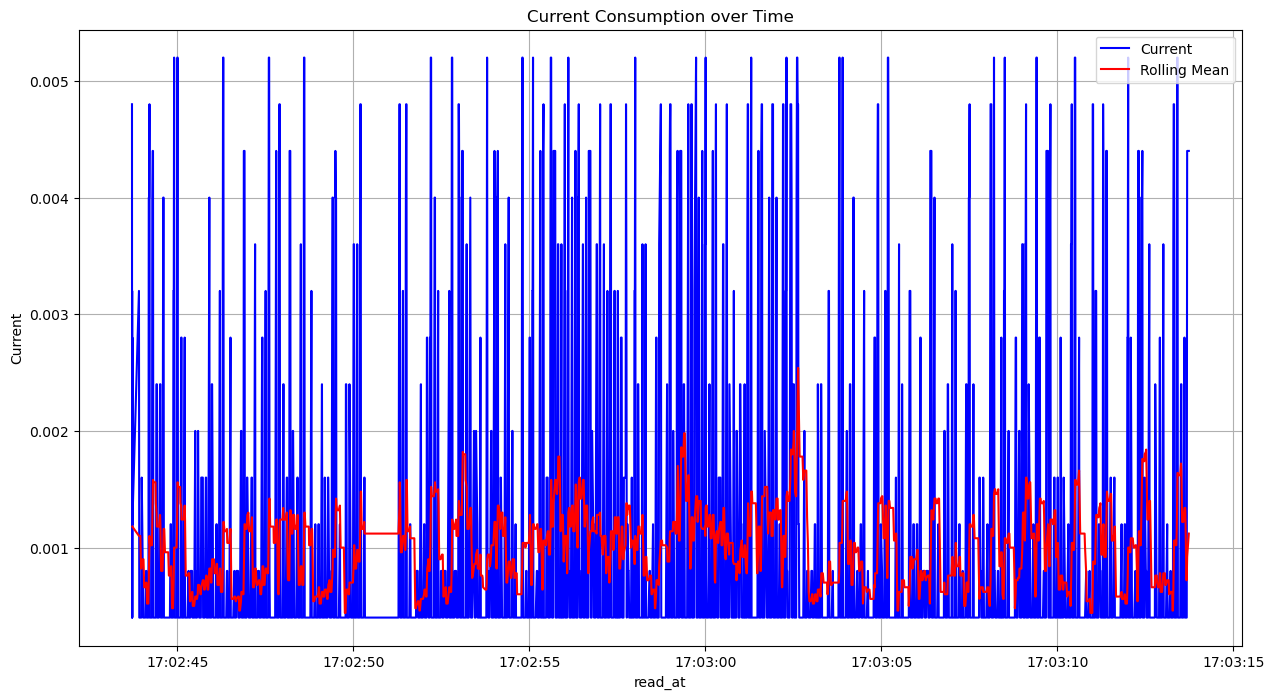

In [10]:
plt.figure(figsize=(15, 8))
plt.plot(df['read_at'], df['current'], label='Current', color='blue')
plt.plot(df['read_at'], df['rolling_mean'], label='Rolling Mean', color='red')

plt.xlabel('read_at')
plt.ylabel('Current')
plt.title('Current Consumption over Time')
plt.legend()
plt.grid(True)
plt.show()